In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("D:\\PGP IN DATA SCIENCE with Careerera\\Data Sets\\data-for-time-series\\AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
import datetime as dt
df['Date']=pd.to_datetime(df['Month'], format='%Y-%m')
df=df.set_index('Date')
df.drop('Month', axis=1, inplace=True)
df.rename({'Date':'Month','#Passengers':'Passengers'}, axis=1, inplace=True)
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Check trend & Seasonality

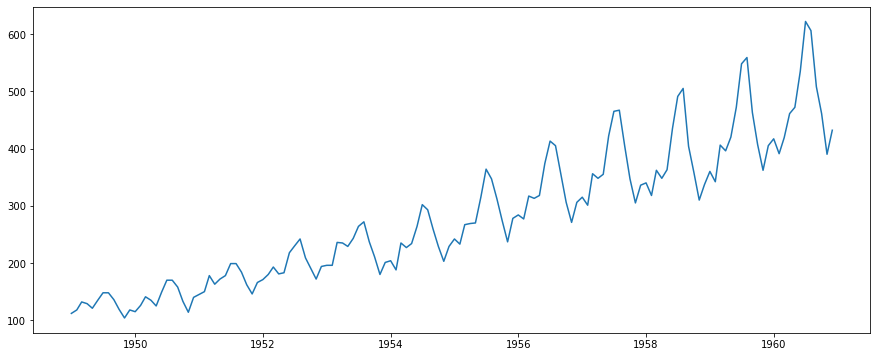

In [4]:
ts=df['Passengers']
plt.plot(ts);

Our Data Has Trend & Seasonality both.

#### Stationarity check:

In [5]:
# transform series
ts_log=np.log(ts)

In [6]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [7]:
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=52,center=False).mean()
    rolstd=timeseries.rolling(window=52,center=False).std()
    
    orig=plt.plot(timeseries,color='blue',label="Original")
    mean=plt.plot(rolmean,color='red',label="Rolling Mean")
    std=plt.plot(rolstd,color='black',label="Rolling STD")
    plt.legend(loc='best')
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block=False)
    
    print("Results of Dickey-Fuller Test:")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-Value','Lags used','No. of Observations used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s) '%key]=value
    print(dfoutput)

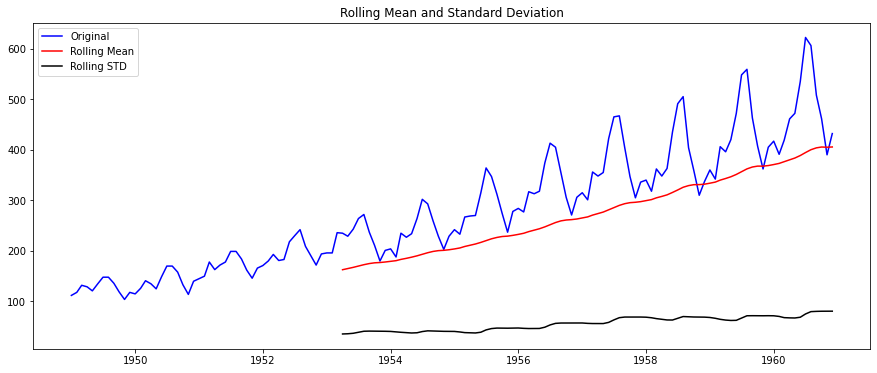

Results of Dickey-Fuller Test:
Test Statistic                0.815369
p-Value                       0.991880
Lags used                    13.000000
No. of Observations used    130.000000
Critical Value (1%)          -3.481682
Critical Value (5%)          -2.884042
Critical Value (10%)         -2.578770
dtype: float64


In [8]:
test_stationarity(df['Passengers'])

p-value is greater than 0.05 and moving average is not constant. Hence Series in Non-Stationary.

#### Decompose the data

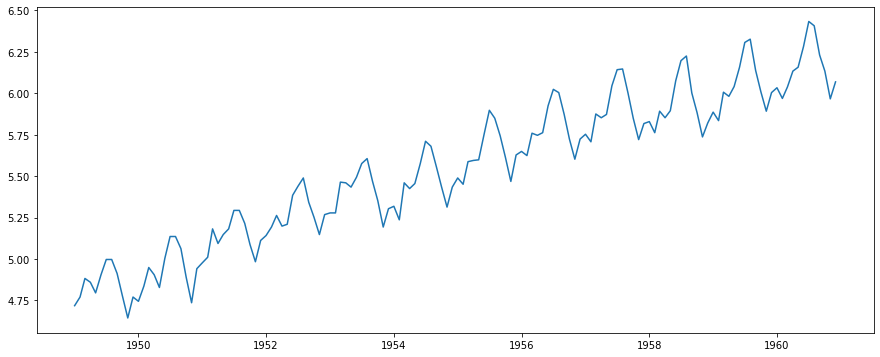

In [9]:
plt.plot(ts_log)

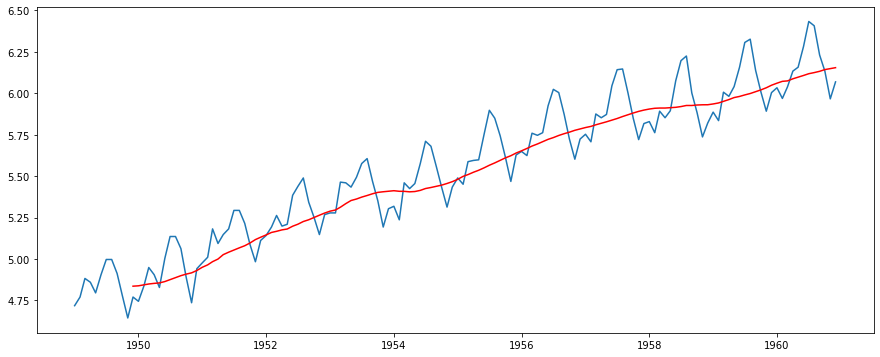

In [10]:
movingAverage=ts_log.rolling(window=12).mean()
movingSTD=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red');

In [12]:
ts_log_mv_diff=ts_log - movingAverage
ts_log_mv_diff.head(12)
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Date
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
Name: Passengers, dtype: float64

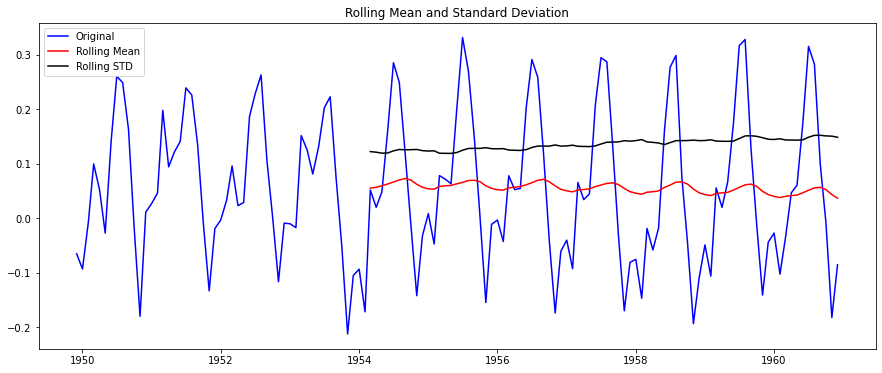

Results of Dickey-Fuller Test:
Test Statistic               -3.162908
p-Value                       0.022235
Lags used                    13.000000
No. of Observations used    119.000000
Critical Value (1%)          -3.486535
Critical Value (5%)          -2.886151
Critical Value (10%)         -2.579896
dtype: float64


In [13]:
test_stationarity(ts_log_mv_diff)

Here p-value is well less than 0.05 and moving average and standard deviation is constant.

### Forecast using ARIMA

#### Plot ACF

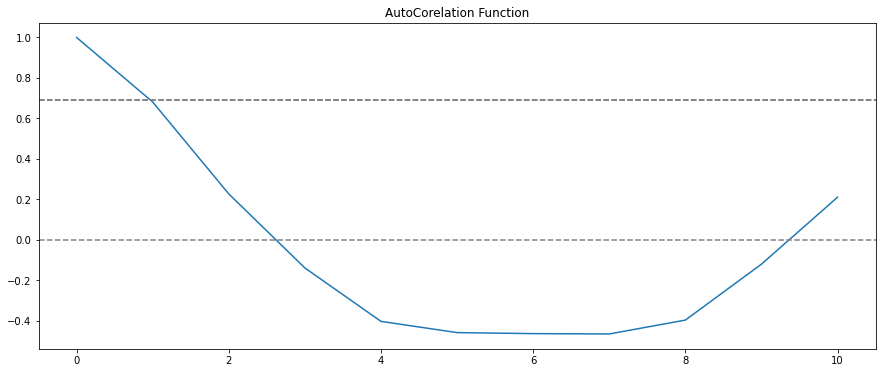

In [18]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.title("AutoCorelation Function")
plt.show()

AFC curve crosses upper confident value(0.95), when the lag value is between 0 & 1, Hence Optimum value of q is 0 or 1.

#### Plot PACF

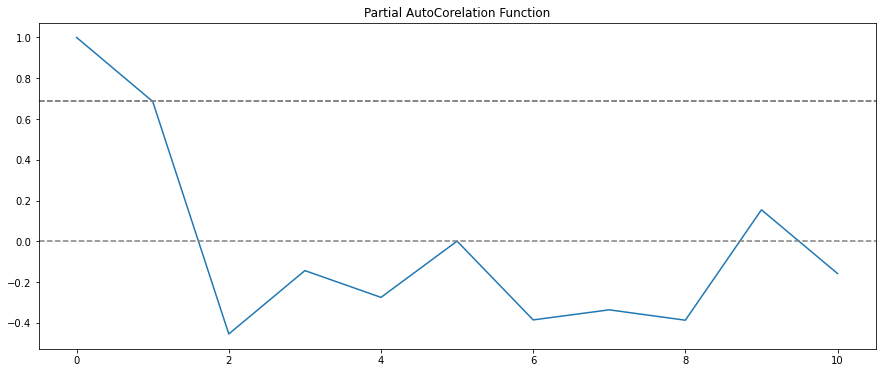

In [20]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='grey')
plt.title("Partial AutoCorelation Function")
plt.show()

PACF curve drop to 0 when lag value is between 0 to 2 thus optimum value of p is 1 or 2.5 .

Text(0.5, 1.0, 'RSS: nan')

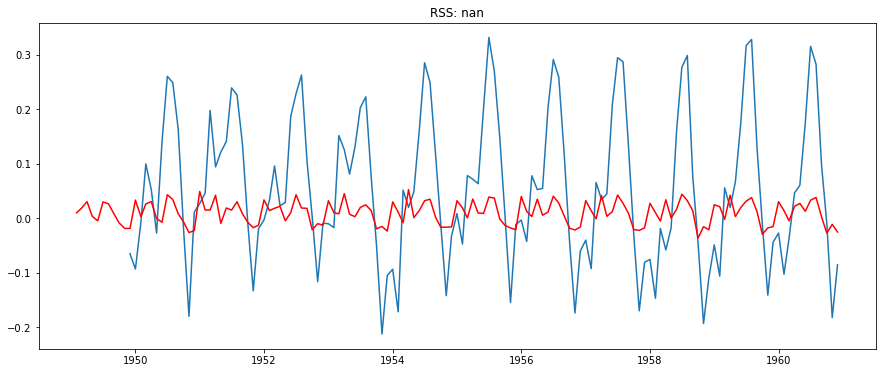

In [26]:
model =ARIMA(ts_log, order=(1,1,0))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2)

#### Predict the Passengers number

In [27]:
predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1949-02-01    0.009676
1949-03-01    0.018164
1949-04-01    0.030130
1949-05-01    0.003154
1949-06-01   -0.005039
dtype: float64

In [29]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1949-02-01    0.009676
1949-03-01    0.027839
1949-04-01    0.057969
1949-05-01    0.061123
1949-06-01    0.056084
dtype: float64

In [31]:
predictions_ARIMA_log=pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1949-01-01    4.718499
1949-02-01    4.728175
1949-03-01    4.746338
1949-04-01    4.776468
1949-05-01    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

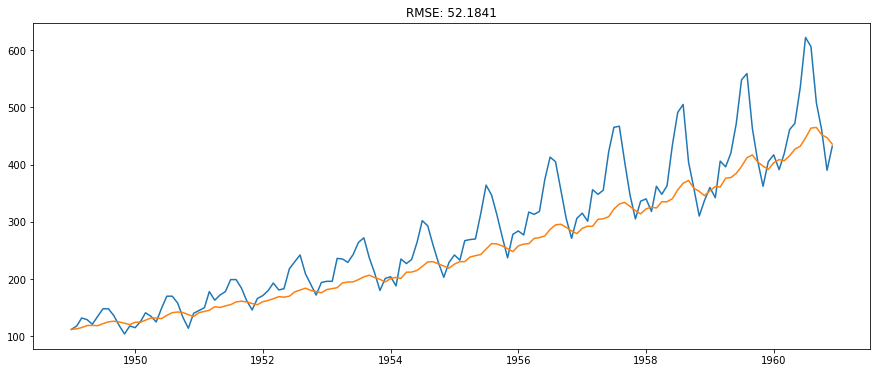

In [32]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))